
#תיקון אחוזי הצבעה + הצגת הצבעה על פי משתנים סוציו-אקונומיים


In [ ]:
import numpy as np  # a module for working with numerical array 
import pandas as pd  # a module for working with data-frames
from matplotlib import pyplot as plt
import random
import statsmodels.api as sm
import io
import matplotlib as mp
import sys
from scipy import stats
import statsmodels.api as sm
from matplotlib.pyplot import figure
import random # Of random import sample # Q 2,a


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Add a check if we run in google colab or locally in jupyter notebook
run_in_colab = False
if 'google.colab' in str(get_ipython()):
    run_in_colab = True
    print('Running on CoLab')
else:
    print('Running locally on Jupyter')

 
if run_in_colab:
    from google.colab import files
    uploaded = files.upload()

Running on CoLab


Saving eshkol_hevrati_calcali.xlsx to eshkol_hevrati_calcali.xlsx
Saving votes per ballot 2021.csv to votes per ballot 2021.csv


In [ ]:
# From previous lectures
data_type = "ballot"  # city
if   run_in_colab:
    df_2021_raw = pd.read_csv(io.BytesIO(uploaded['votes per ballot 2021.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
else:  # read local file
    if data_type == "ballot":
        df_2021_raw = pd.read_csv(data_path + 'votes per ballot 2021.csv',  encoding = 'iso-8859-8', index_col='שם ישוב')
        # preprocessing of ballot
        df_2021 = df_2021_raw.drop('סמל ועדה', axis=1) # new column added in Sep 2019
        df_2021 = df_2021[df_2021.columns[8:-1]] # removing "metadata" columns
    else:
        df_2021_raw = pd.read_csv(data_path + 'votes per city 2021.csv',  encoding = 'iso-8859-8', index_col='שם ישוב')
        # preprocessing of cities 
        df_2021 = df_2021_raw.drop('סמל ועדה', axis=1) # new column added in Sep 2019
        df_2021 = df_2021[df_2021.columns[5:-1]] # removing "metadata" columns
# Dataset is now stored in a Pandas Dataframe
df_2021_raw = df_2021_raw[df_2021_raw.index != 'מעטפות חיצוניות']

# From previous lectures
df_2021 = df_2021_raw
df_2021 = df_2021[df_2021.columns[10:-1]] # removing "metadata" columns

df_2021= df_2021.rename(columns={'אמת' : "עבודה", 'מרצ' : "מרצ",  'ג' : "יהדות התורה", 'עם'  : "רעם",  'ת'  : "תקוה חדשה", 'ודעם'  : "הרשימה המשותפת", 'ב'  : "ימינה", 'ט'  : "הציונות הדתית",
 'ל'  : "ישראל ביתנו", 'מחל'  : "הליכוד",  'פה'  : "יש עתיד", 'כן'  : "כחול לבן", 'שס'  : "שס"})

In [ ]:
# using lab 3,2
def parties_above_blocking_precentage(df, thresh):
    par = df.sum().div(df.sum().sum()).sort_values(ascending=False)
    return par[par > thresh]

votes = parties_above_blocking_precentage(df_2021, 0.015)  # total votes for each party

names = votes.keys() # 13 parties

# Data with only the 13 relevant parties:
df_2021_new = df_2021[names]

## Question 1




Elections results correction

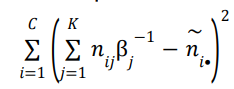

In [ ]:
def ols_correction(dataframe, voters):
    prob = dataframe.sum().div(dataframe.sum().sum()) 
    # a vector of probebilties for all parties which disaply the precentage, votes without correction of lab 3
    suffragiums = dataframe.sum(axis=1) / voters 
    # as required as a fix  while 'voters' use a binom sample
    model = sm.OLS(suffragiums, dataframe).fit()
    # https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html - [5]
    # linear regression withiout β0
    q_hat = prob * model.params 
    # probebilties for all parties which disaply the precentage * model.paramameters of OLS
    # https://www.gurobi.com/documentation/9.1/refman/py_model_setparam.html - Example usage
    q_hat = q_hat / q_hat.sum()  
    return prob, q_hat, model.params 

## Question 2




Simulations same as in lab 3

From lab3: Function that recieves the N~ and V matrices and samples binomial votes

In [ ]:
# from lab 2
def binom_simlation(nij,Vij):
  new_data = pd.DataFrame(np.random.binomial(nij,Vij))
  new_data.index = df_2021.index
  v = new_data.sum(axis=1)/ nij.sum(axis=1)
  return new_data, v

#### Run simulations and apply corrections

Computing N~ and Vi for the 3 simulations as pwe lab 3:

In [ ]:
n_tilde = np.array(df_2021_new.mul(df_2021_raw['בזב'].sum()).div(df_2021_raw['כשרים'].sum()),dtype='int32')
#N_tilde

## 3 types of Vij in lab 3/Q2:

# αi - i
alpha = df_2021_raw['כשרים'].div(df_2021_raw['בזב'])

# βj - ii

beta = list([0.3,0.5,0.25,0.4,0.7,0.65,0.2,0.45,0.6,0.35,0.55,0.8,0.75])
# βj randomly - iii
beta_random = random.sample(beta, len(beta))


dim_of_df = df_2021.shape

Vai = np.tile(np.array([alpha]).transpose(), (1, len(names)))

Vbj = np.tile(np.array(beta),(dim_of_df[0], 1))


Vbj_random = np.tile(np.array(beta_random),(dim_of_df[0],1))



In [ ]:
def fixing_data(df, fix_param):
  p = parties_above_blocking_precentage(df, 0) 
  q_hat = parties_above_blocking_precentage(df.div(fix_param, axis = "rows"), 0)
  return q_hat


In [ ]:
def simulations(n,dataset,V):
  p = np.zeros([n, 13])
  q_hat = np.zeros([n, 13]) 
  q_hat_ols = np.zeros([n, 13]) 

  # in every simulation we calculate p and q_hat (after fixing the data)
  for i in range(0,n):
    new_df, v = binom_simlation(dataset,V)
    q_hat[i,] = fixing_data(new_df, v)     #as per lab 3
    p[i,], q_hat_ols[i,] = ols_correction(new_df, v)[0:2]


  return p, q_hat, q_hat_ols


In [ ]:

q_real = n_tilde.sum(axis=0)/(n_tilde.sum())

sim_alpha = simulations(50, n_tilde, Vai)
mean_p_ai = np.nanmean(sim_alpha[0],axis=0)
mean_q_ai = np.nanmean(sim_alpha[1],axis=0)
mean_q_ai_alpha = np.nanmean(sim_alpha[2],axis=0)

##################################################
sim_beta = simulations(50, n_tilde, Vbj)
mean_p_beta = sim_beta[0].mean(axis=0) 
mean_q_beta = sim_beta[1].mean(axis=0) 
mean_q_beta_alpha = sim_beta[2].mean(axis=0)

##################################################
sim_beta_random = simulations(50, n_tilde, Vbj_random)
mean_p_beta_random = sim_beta_random[0].mean(axis=0)
mean_q_beta_random = sim_beta_random[1].mean(axis=0)
mean_q_beta_random_alpha = sim_beta_random[2].mean(axis=0)



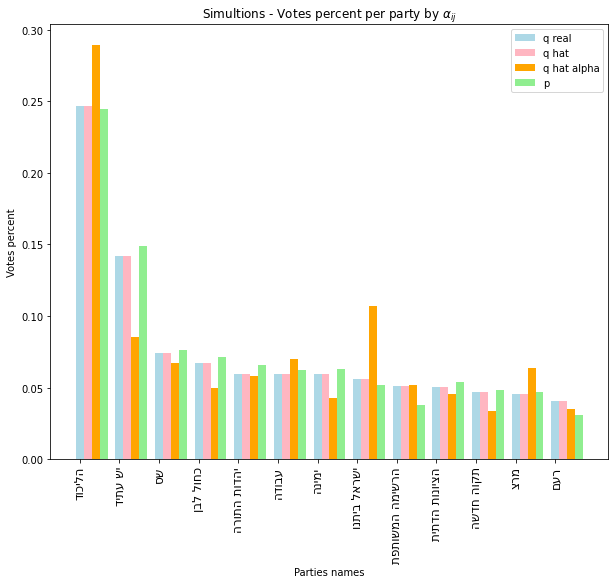

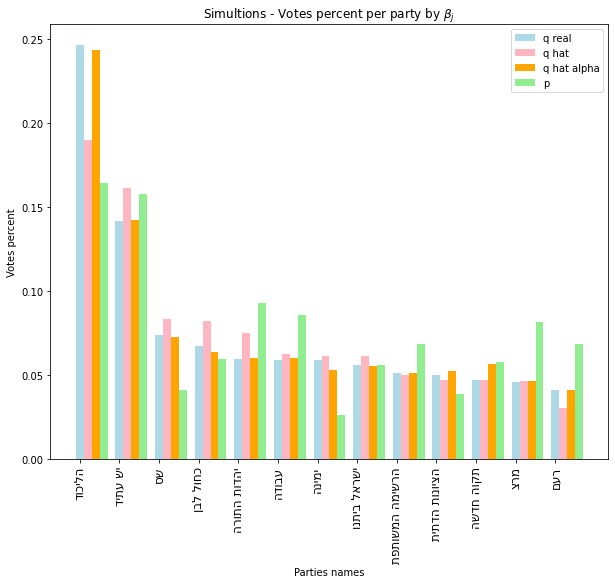

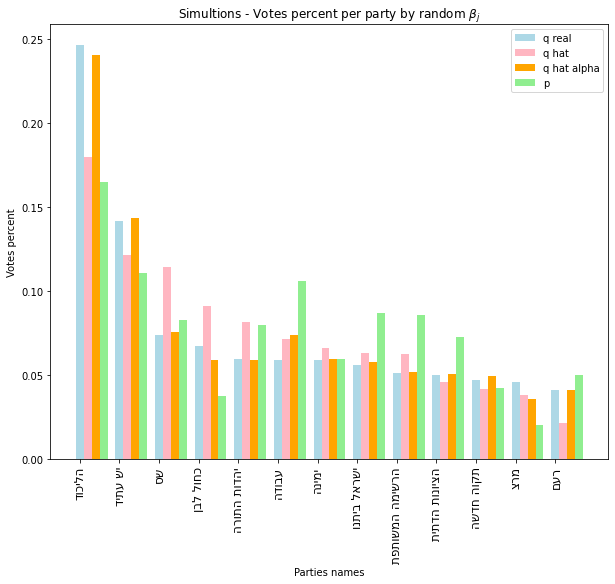

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f824d791cd0>)

In [ ]:
def party_bar_fix(q_real, q_hat, q_hat_alpha, p, t):
    width = 0.2  # set column width 
    #n = len(total_votes)
    n = len(votes)

    rev_names = [name[::-1] for name in list(names)]
    fig, ax = plt.subplots(figsize=(10,8)) 

    q_real_bar = ax.bar(np.arange(n), list(q_real), width, color='lightblue')
    q_hat_bar = ax.bar(np.arange(n)+width, q_hat, width, color='lightpink')
    q_hat_alpha_bar = ax.bar(np.arange(n)+2*width, q_hat_alpha, width,  color='orange')
    p_bar = ax.bar(np.arange(n)+3*width, p, width, color='lightgreen')


    ax.set_ylabel('Votes percent')
    ax.set_xlabel('Parties names')
    ax.set_title('Simultions - Votes percent per party by '+ t)
    ax.set_xticks(np.arange(n))
    ax.set_xticklabels(rev_names)
    ax.legend((q_real_bar, q_hat_bar, q_hat_alpha_bar, p_bar), ('q real', 'q hat', 'q hat alpha', 'p'))
    plt.xticks(rotation=90, size = 12)
    plt.show()

    return fig, ax

party_bar_fix(q_real, mean_q_ai,mean_q_ai_alpha, mean_p_ai,r'$\alpha_{ij}$')

party_bar_fix(q_real, mean_q_beta, mean_q_beta_alpha, mean_p_beta,  r'$\beta_j$')

party_bar_fix(q_real, mean_q_beta_random, mean_q_beta_random_alpha, mean_p_beta_random, r'random $\beta_j$')



בהשווה לתיקון  במעבדה 3, תיקון זה פחות טוב.ערכי האומד לשכיחות האוכלוסיה של כל מפלגה
 יצאו פחות תואמים לקיו המקורי כפי שיצאו בתיקון הקודם שאינו עם אומד ריבועים פחותים. נעדיף 
 שלא להשתמש בתיקון זה, שנראה כי בעל הטיה גדולה יותר בשונה מהמציאות.
 
 תזכורת - התיקון של מעבדה 3:

 A function that calculates the p and the $\hat{q}$ (after fixing data to 100% votes with $V_i= \frac{kosher_i}{bzb_i}$)
 


## Question 3

In [ ]:
#upload the cities and "eshkolot" files.
run_in_colab = False
if 'google.colab' in str(get_ipython()):
    run_in_colab = True
    print('Running on CoLab')
else:
    print('Running locally on Jupyter')

 
if run_in_colab:
    from google.colab import files
    uploaded = files.upload()

In [ ]:
if   run_in_colab:
    df_2021_cities_raw = pd.read_csv(io.BytesIO(uploaded['votes per city 2021.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
    df_2021_eshkolot = pd.read_excel(io.BytesIO(uploaded['eshkol_hevrati_calcali.xlsx']), index_col='name')
else:
    df_2021_cities_raw = pd.read_csv(data_path + 'votes per city 2021.csv',  encoding = 'iso-8859-8', index_col='שם ישוב')  
    df_2021_eshkolot = pd.read_excel('eshkol_hevrati_calcali.xlsx', index_col='name')

df_cities = df_2021_cities_raw.drop('סמל ועדה', axis=1)
df_cities = df_cities[df_cities.columns[5:-1]]
df_cities['סמל ישוב'] = df_2021_cities_raw['סמל ישוב']
df_cities = df_cities.rename(columns={'אמת' : "עבודה", 'מרצ' : "מרצ",  'ג' : "יהדות התורה", 'עם'  : "רעם",  'ת'  : "תקוה חדשה", 'ודעם'  : "הרשימה המשותפת", 'ב'  : "ימינה", 'ט'  : "הציונות הדתית",
 'ל'  : "ישראל ביתנו", 'מחל'  : "הליכוד",  'פה'  : "יש עתיד", 'כן'  : "כחול לבן", 'שס'  : "שס"})

In [ ]:
#creating a merged data frame

merged_data = df_cities.join(df_2021_eshkolot.set_index('set_code'), on='סמל ישוב')
merged_data = merged_data.dropna()
merged_data = merged_data.rename(columns={'אמת' : "עבודה", 'מרצ' : "מרצ",  'ג' : "יהדות התורה", 'עם'  : "רעם",  'ת'  : "תקוה חדשה", 'ודעם'  : "הרשימה המשותפת", 'ב'  : "ימינה", 'ט'  : "הציונות הדתית",
 'ל'  : "ישראל ביתנו", 'מחל'  : "הליכוד",  'פה'  : "יש עתיד", 'כן'  : "כחול לבן", 'שס'  : "שס"})

print("The number of shared cities is- " + str(merged_data.shape[0]))

In [ ]:
print(merged_data.index)

In [ ]:
num_of_losts = df_cities.shape[0]-merged_data.shape[0]
print("The number of cities we lost is- " + str(num_of_losts))

In [ ]:
df_eshkolot_cities = merged_data[names]
shared_cities_precent = df_eshkolot_cities.sum().div(df_eshkolot_cities.sum().sum())
all_cities_precent = df_cities[names].sum().div(df_cities[names].sum().sum())

In [ ]:
def parties_bar(all_p, eshkolot_p):
  width = 0.3
  #n = len(total_votes)
  n = len(votes)

  rev_names = [name[::-1] for name in list(names)]
  fig, ax = plt.subplots(figsize=(10,8)) 

  all_p = ax.bar(np.arange(n), list(all_p), width, color = 'lightblue')
  eshkolot_p = ax.bar(np.arange(n)+width, list(eshkolot_p), width, color = 'orange')
  ax.set_ylabel('Votes percent')
  ax.set_xlabel('Parties names')
  ax.set_title('Votes percent per party by all cities and only on socio cities')
  ax.set_xticks(np.arange(n))
  ax.set_xticklabels(rev_names)
  ax.legend((all_p, eshkolot_p,), ('precent all cities', 'precent only socio cities'))
  plt.xticks(rotation=90, size = 12)
  plt.show()

  return fig, ax

parties_bar(all_cities_precent, shared_cities_precent)



##Question 4

###a. Subplots of votes by eshkol

In [ ]:
fr_dict = {names[0]:list(),names[1]:list(),names[2]:list(),names[3]:list(),names[4]:list(),names[5]:list(),names[6]:list(),names[7]:list(), names[8]:list(), names[9]:list(), names[10]:list(), names[11]:list(), names[12]:list()}

for eshkol in range(10):
  cities = np.where(merged_data['eco_level'].values.astype('float') == eshkol+1)[0]
  percent4 = merged_data.iloc[cities][names].sum().div(merged_data.iloc[cities][names].sum().sum())
  parties = percent4.keys()
  for j in range(len(names)):
    fr_dict[parties[j]].append(percent4[j])

freq_df = pd.DataFrame(fr_dict, index=list(range(1, 11)))

In [ ]:
rev_names = [name[::-1] for name in list(names)]
color_vec= ['peachpuff','lightsalmon','salmon','darksalmon','rosybrown','plum','cadetblue','skyblue','mediumspringgreen','palegreen']

figure(figsize=(20,10))
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.title('Eshkol %i' %(i+1),fontsize=16)
  plt.ylabel("Votes rate",fontsize=13)
  plt.xlabel("parties",labelpad=-15,fontsize=13)
  plt.xticks(rotation=90,fontsize=11)
  plt.bar(rev_names,freq_df.iloc[i,:],color=color_vec[i])
  plt.tight_layout()

###b. Subplots of votes percentages by eshkol

In [ ]:
color_vec2 = ['mediumorchid','crimson','coral','yellow','crimson','coral','yellow','lawngreen','coral','yellow','lawngreen','dodgerblue','yellow']

figure(figsize=(20,10))
for i in range(len(names)):
  plt.subplot(4,4,i+1)
  plt.title(rev_names[i], fontsize=16)
  plt.ylabel('Votes rate',fontsize=13)
  plt.xlabel('Social Eshkol', fontsize=13)
  plt.xticks(fontsize=11)
  plt.xlim([1,10])
  plt.bar(freq_df.index,freq_df.iloc[:,i],color=color_vec2[i])
  plt.tight_layout()

Bar plots for each party, showing voting rates from each social eshkol. There are 13 polts in a 4x4 grid, such that the last three sopts are empty.